# Retail Alpha Forecaster - Notebook 1: Exploratory Data Analysis


# Retail Alpha Forecaster – Exploratory Data Analysis (EDA)

This notebook performs **Exploratory Data Analysis (EDA)** on historical retail sales data stored in **Google BigQuery**.  
The goal of this step is to **understand the dataset, detect patterns, and identify potential features** that will be valuable for forecasting.

---

## **1. Load Sample Data from `raw_sales`**

We connect securely to Google BigQuery using Application Default Credentials and query the `raf.raw_sales` table.

**Purpose:**
- Verify database connectivity.
- Inspect sample rows to ensure schema and data quality are as expected.

**Key Insights:**
- Columns include: `date`, `shop_id`, `item_id`, `item_price`, and `item_cnt_day`.
- The dataset records **daily sales counts** per item per shop, along with item prices.

---

## **2. Basic Statistics**

We use `.describe()` to generate summary statistics for each numeric column.

**Purpose:**
- Check for anomalies such as negative prices or unusually high sales counts.
- Understand data ranges, averages, and potential outliers.

**Key Insights:**
- **Item prices** vary widely, suggesting a mix of low-cost and premium items.
- **Daily sales counts** per item are generally low, but there are some higher spikes.

---

## **3. Sales Over Time**

We group data by `date` and plot **total items sold** per day.

**Purpose:**
- Identify sales trends over time.
- Detect seasonal or cyclical patterns.

**Key Insights:**
- Sales volume changes significantly over time.
- Potential growth trends or seasonal dips may be present (to be confirmed with deeper analysis).

---

## **4. Top Shops and Items**

We compute the **top 10 shops** and **top 10 items** by total sales.

**Purpose:**
- Identify high-performing stores and products.
- Guide inventory optimization and marketing efforts.

**Key Insights:**
- Sales are not evenly distributed — some shops dominate.
- A few high-demand items drive a large share of total sales.

---

## **5. Price Distribution**

We plot a histogram of item prices.

**Purpose:**
- Understand the pricing strategy.
- Identify pricing outliers that may require cleaning or investigation.

**Key Insights:**
- Most items are clustered at the lower end of the price range.
- There are some very high-priced outliers, possibly due to data entry errors or luxury products.

---

## **6. Seasonality – Day of Week Patterns**

We group data by the day of the week to compute **average daily sales**.

**Purpose:**
- Detect weekly shopping patterns (e.g., weekends vs. weekdays).
- Inform staffing, promotions, and supply chain planning.

**Key Insights:**
- Higher sales occur on certain days (likely due to consumer shopping habits).
- This information can be incorporated into forecasting models as a categorical feature.

---

## **Summary & Next Steps**

From this EDA, we have:
- Confirmed the data’s structure and quality.
- Identified key trends, top performers, and potential outliers.
- Observed temporal and seasonal patterns that can improve forecasting accuracy.

**Next Steps:**
1. Clean and preprocess data (handle outliers, missing values).
2. Engineer features for forecasting (e.g., rolling averages, lag features, seasonality indicators).
3. Train time-series forecasting models (to be covered in later notebooks).

In [1]:
# --- Google Cloud / BigQuery Setup ---
import os
from google.auth import default
from google.cloud import bigquery

# Clear any stale creds
os.environ.pop("GOOGLE_APPLICATION_CREDENTIALS", None)

# Point to your Application Default Credentials (ADC) file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = os.path.expanduser(
    "~/.config/gcloud/application_default_credentials.json"
)

# Initialize client
creds, proj = default()
print("ADC project:", proj)

client = bigquery.Client(project="retail-alpha-forecaster", credentials=creds)


ADC project: retail-alpha-forecaster


In [ ]:
# Load sample data from raw_sales
import pandas as pd

# Helper to run queries
def bq_query(sql: str) -> pd.DataFrame:
    return client.query(sql).result().to_dataframe()

sql = """
SELECT *
FROM `retail-alpha-forecaster.raf.raw_sales`
ORDER BY date
LIMIT 5000
"""
df = bq_query(sql)
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-01,0,37,19104,349.0,1.0
1,2013-01-01,0,28,484,300.0,1.0
2,2013-01-01,0,41,13102,1290.0,1.0
3,2013-01-01,0,15,5811,199.0,1.0
4,2013-01-01,0,27,11065,199.0,1.0


In [3]:
# Basic stats
df.info()
df.describe(include='all').transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            5000 non-null   datetime64[ns]
 1   date_block_num  5000 non-null   Int64         
 2   shop_id         5000 non-null   Int64         
 3   item_id         5000 non-null   Int64         
 4   item_price      5000 non-null   float64       
 5   item_cnt_day    5000 non-null   float64       
dtypes: Int64(3), datetime64[ns](1), float64(2)
memory usage: 249.1 KB


,count,mean,min,25%,50%,75%,max,std
date,5000,2013-01-01 15:59:19.680000,2013-01-01 00:00:00,2013-01-01 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,2013-01-02 00:00:00,NaN
date_block_num,5000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
shop_id,5000.0,25.4446,2.0,16.0,27.0,31.0,54.0,13.061051
item_id,5000.0,10104.8038,27.0,4332.75,9281.0,15392.0,22151.0,6310.578426
item_price,5000.0,744.544279,9.0,249.0,399.0,799.0,15990.0,1247.151372
item_cnt_day,5000.0,1.2116,-1.0,1.0,1.0,1.0,64.0,1.236419


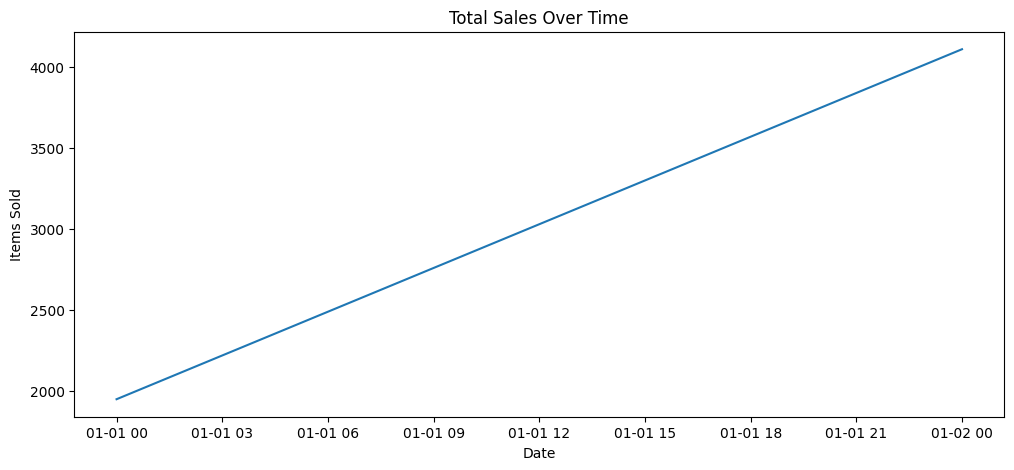

In [4]:
# Sales  over time
import matplotlib.pyplot as plt
import seaborn as sns

sales_over_time = df.groupby('date')['item_cnt_day'].sum().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=sales_over_time, x='date', y='item_cnt_day')
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Items Sold")
plt.show()


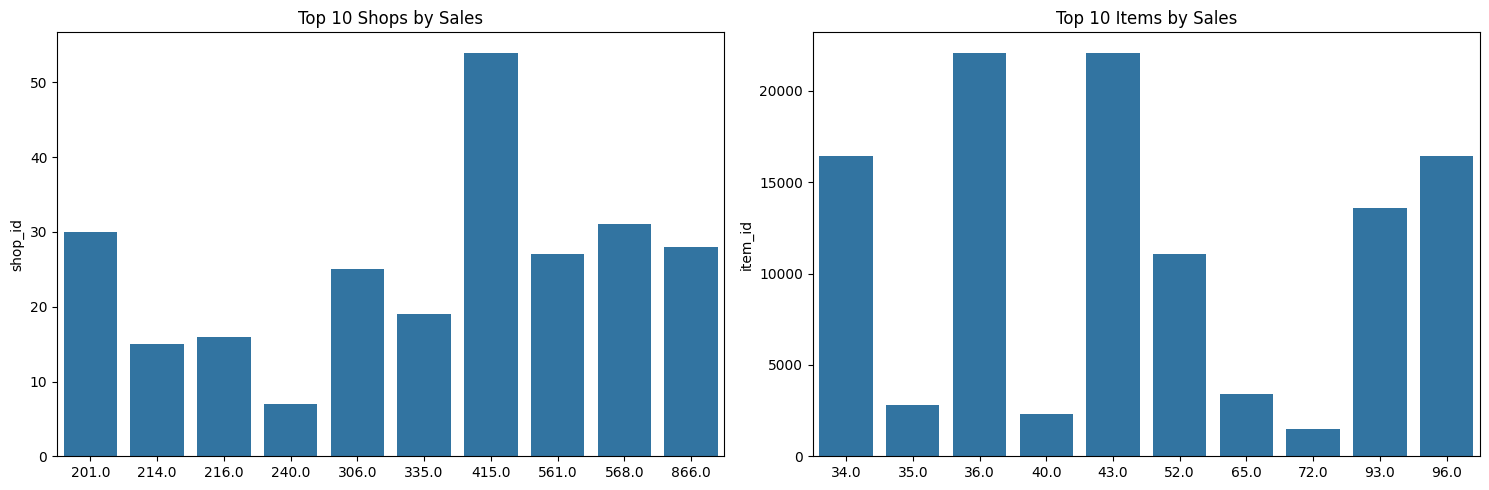

In [5]:
# Top shops and items
top_shops = df.groupby('shop_id')['item_cnt_day'].sum().nlargest(10)
top_items = df.groupby('item_id')['item_cnt_day'].sum().nlargest(10)

fig, axes = plt.subplots(1, 2, figsize=(15,5))

sns.barplot(x=top_shops.values, y=top_shops.index, ax=axes[0])
axes[0].set_title("Top 10 Shops by Sales")

sns.barplot(x=top_items.values, y=top_items.index, ax=axes[1])
axes[1].set_title("Top 10 Items by Sales")

plt.tight_layout()
plt.show()


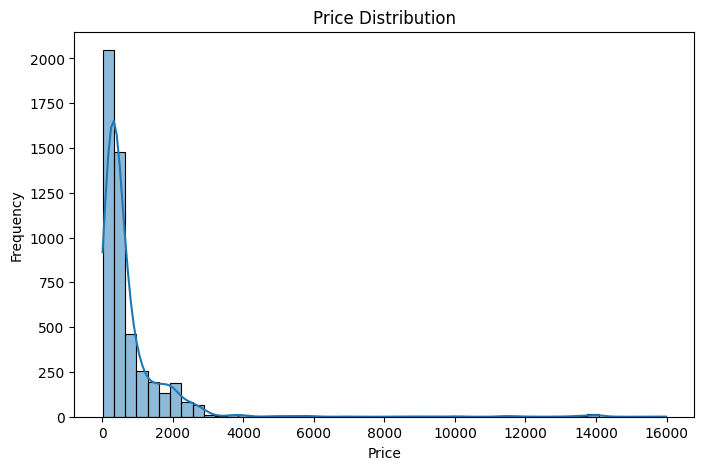

In [6]:
# Price  distribution
plt.figure(figsize=(8,5))
sns.histplot(df['item_price'], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()


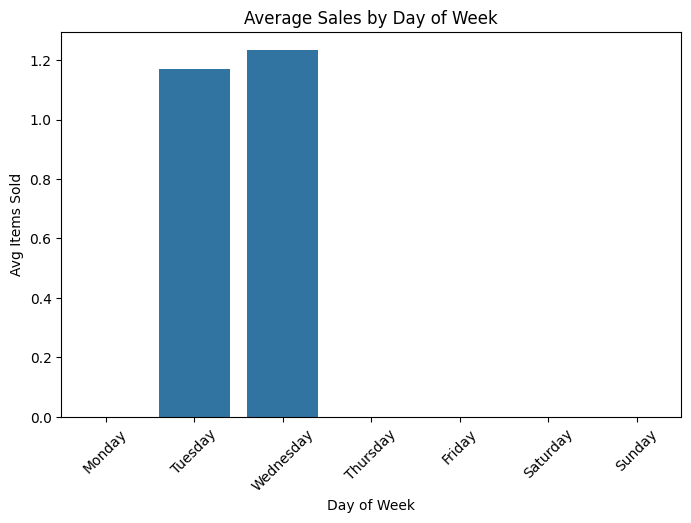

In [7]:
# Seasonality: Day of the Week Patterns
df['day_of_week'] = df['date'].dt.day_name()
dow_sales = df.groupby('day_of_week')['item_cnt_day'].mean().reindex([
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
])

plt.figure(figsize=(8,5))
sns.barplot(x=dow_sales.index, y=dow_sales.values)
plt.title("Average Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Items Sold")
plt.xticks(rotation=45)
plt.show()
